# RAGAS 대표 리랭커 성능 평가 (최적화 버전)

이 노트북은 **각 카테고리별 대표 리랭커 5개**를 대상으로 RAGAS 메트릭을 사용한 성능 평가를 수행한다.

## 평가 대상 대표 리랭커들 (5개)
- **BM25 계열**: BM25 기본 (1개)
- **CrossEncoder 계열**: Cohere (1개)
- **Hybrid 계열**: CombSum (1개)
- **LLM 계열**: LLM 기본 (1개)
- **Rules 계열**: Legal Rule Boost (1개)

## RAGAS 메트릭
- **Context Precision**: 검색된 컨텍스트의 정확성
- **Context Recall**: 관련 컨텍스트의 검색 완성도  
- **Faithfulness**: 생성된 답변의 신뢰성
- **Answer Relevancy**: 답변의 관련성

## 라이브러리 & GPU 로드

In [1]:
# 환경 설정
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any, Optional
import warnings
import time
from datetime import datetime
import torch
warnings.filterwarnings('ignore')

# GPU 설정 및 확인
def setup_gpu():
    """GPU 설정 및 확인"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_count = torch.cuda.device_count()
        gpu_name = torch.cuda.get_device_name(0)
        print(f" GPU 사용 가능: {gpu_name}")
        print(f" GPU 개수: {gpu_count}개")
        print(f" 사용할 디바이스: {device}")
        
        # GPU 메모리 정보 출력
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f" GPU 총 메모리: {total_memory:.2f}GB")
        
        return device
    else:
        print(" GPU를 사용할 수 없습니다. CPU를 사용합니다.")
        return torch.device("cpu")

# GPU 설정 실행
DEVICE = setup_gpu()

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 프로젝트 경로 설정
BASE_DIR = Path.cwd()
RERANKERS_DIR = BASE_DIR / "RAG_with_Various_Rerankers"
EMB_PATH = BASE_DIR / "output_chunks_with_embeddings.json"
QA_PATH = BASE_DIR / "real_estate_tax_QA.json"

# 패키지 경로 추가
sys.path.insert(0, str(RERANKERS_DIR))

print(f" 평가 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BASE_DIR: {BASE_DIR}")
print(f"RERANKERS_DIR: {RERANKERS_DIR}")
print(f"EMB_PATH exists: {EMB_PATH.exists()}")
print(f"QA_PATH exists: {QA_PATH.exists()}")

 GPU 사용 가능: NVIDIA GeForce RTX 4080 Laptop GPU
 GPU 개수: 1개
 사용할 디바이스: cuda
 GPU 총 메모리: 11.99GB
 평가 시작 시간: 2025-11-30 00:16:53
BASE_DIR: c:\Users\Lenovo\Study\부동산세, Advanced RAG를 활용한 생성형AI 법무자문 서비스 프로젝트\RAG_Retriever_Reranker_Experiment
RERANKERS_DIR: c:\Users\Lenovo\Study\부동산세, Advanced RAG를 활용한 생성형AI 법무자문 서비스 프로젝트\RAG_Retriever_Reranker_Experiment\RAG_with_Various_Rerankers
EMB_PATH exists: True
QA_PATH exists: True


## 리랭커 로드

In [2]:
# 각 카테고리별 대표 리랭커 1개씩 선별 (총 7개)
REPRESENTATIVE_RERANKER_MODULES = [
    # BM25 계열 대표 (CPU 기반, 빠르고 안정적)
    ("BM25_Reranker.RAG_BM25_Rerank_FINAL", "BM25 기본", "LegalRAGSystemBM25Rerank"),
    
    # CrossEncoder 계열 대표 (Cohere Reranker)
    ("CrossEncoder.RAG_Cohere_Rerank_FINAL", "Cohere", "LegalRAGSystemCohereRerank"),
    
    # BGE 계열 대표 (최적화된 버전 - 메모리 효율성 개선)(bge-reranker-v2-m3 모델)
    # ("CrossEncoder.BGE 계열.RAG_BGE_Base_Optimized_Rerank_FINAL", "BGE v2-m3", "LegalRAGSystemBGEBase"),
    
    # Embedding 계열 대표 (임베딩 기반)
    # ("Embedding_Reranker.RAG_EmbeddingCosine_E5_Rerank_FINAL", "Embedding E5", "LegalRAGSystemEmbeddingE5"),
    
    # Hybrid 계열 대표 (결합 방법)
    ("Hybrid_Reranker.RAG_CombSum_Rerank_FINAL", "Hybrid CombSum", "LegalRAGSystemCombSum"),
    
    # LLM 계열 대표 (대화형 AI)
    ("LLM_Reranker.RAG_LLM_Rerank_FINAL", "LLM 기본", "LegalRAGSystemLLM"),
    
    # Rules 계열 (규칙 기반)
    ("Rules_Reranker.RAG_LegalRuleBoost_Rerank_FINAL", "Legal Rule Boost", "LegalRAGSystemLegalRuleBoost")
]

# 전체 리랭커 목록 (백업용)
ALL_RERANKER_MODULES = [
    # BM25 리랭커들 (5개)
    ("BM25_Reranker.RAG_BM25_Rerank_FINAL", "BM25 기본", "LegalRAGSystemBM25Rerank"),
    ("BM25_Reranker.RAG_BM25_CharNgram_Rerank_FINAL", "BM25 CharNgram", "LegalRAGSystemBM25CharNgram"),
    ("BM25_Reranker.RAG_BM25_Kiwi_Rerank_FINAL", "BM25 Kiwi", "LegalRAGSystemBM25Kiwi"),
    ("BM25_Reranker.RAG_BM25_Regex_Rerank_FINAL", "BM25 Regex", "LegalRAGSystemBM25Regex"),
    ("BM25_Reranker.RAG_BM25_Stopword_Rerank_FINAL", "BM25 Stopword", "LegalRAGSystemBM25Stopword"),
    
    # CrossEncoder 리랭커들 (7개)
    ("CrossEncoder.RAG_CE_MiniLM_L6_Rerank_FINAL", "CrossEncoder MiniLM L6", "LegalRAGSystemMiniLML6"),
    ("CrossEncoder.RAG_CE_MiniLM_L12_Rerank_FINAL", "CrossEncoder MiniLM L12", "LegalRAGSystemMiniLML12"),
    ("CrossEncoder.RAG_CE_Electra_Rerank_FINAL", "CrossEncoder Electra", "LegalRAGSystemElectra"),
    ("CrossEncoder.RAG_CE_E5_Mistral_Rerank_FINAL", "CrossEncoder E5 Mistral", "LegalRAGSystemE5Mistral"),
    ("CrossEncoder.RAG_Cohere_Rerank_FINAL", "Cohere", "LegalRAGSystemCohereRerank"),
    ("CrossEncoder.RAG_MXBAI_Rerank_FINAL", "MXBAI", "LegalRAGSystemMXBAI"),
    
    # BGE 계열 (4개)
    ("CrossEncoder.BGE 계열.RAG_BGE_Base_Rerank_FINAL", "BGE Base", "LegalRAGSystemBGEBase"),
    ("CrossEncoder.BGE 계열.RAG_BGE_Large_Rerank_FINAL", "BGE Large", "LegalRAGSystemBGELarge"),
    ("CrossEncoder.BGE 계열.RAG_BGE_v2m3_Rerank_FINAL", "BGE v2 M3", "LegalRAGSystemBGEv2m3"),
    ("CrossEncoder.BGE 계열.RAG_Flashrank_BGEv2m3_Rerank_FINAL", "Flashrank BGE v2m3", "LegalRAGSystemFlashrankBGEv2m3"),
    
    # Embedding 리랭커들 (5개)
    ("Embedding_Reranker.RAG_EmbeddingCosine_E5_Rerank_FINAL", "Embedding E5", "LegalRAGSystemEmbeddingE5"),
    ("Embedding_Reranker.RAG_EmbeddingCosine_GTE_Rerank_FINAL", "Embedding GTE", "LegalRAGSystemEmbeddingGTE"),
    ("Embedding_Reranker.RAG_EmbeddingCosine_MPNet_Rerank_FINAL", "Embedding MPNet", "LegalRAGSystemEmbeddingMPNet"),
    ("Embedding_Reranker.RAG_EmbeddingCosine_Paraphrase_Rerank_FINAL", "Embedding Paraphrase", "LegalRAGSystemEmbeddingParaphrase"),
    ("Embedding_Reranker.RAG_EmbeddingCosine_Stella_Rerank_FINAL", "Embedding Stella", "LegalRAGSystemEmbeddingStella"),
    
    # Hybrid 리랭커들 (4개)
    ("Hybrid_Reranker.RAG_CombSum_Rerank_FINAL", "Hybrid CombSum", "LegalRAGSystemCombSum"),
    ("Hybrid_Reranker.RAG_CombMNZ_Rerank_FINAL", "Hybrid CombMNZ", "LegalRAGSystemCombMNZ"),
    ("Hybrid_Reranker.RAG_RRF_Rerank_FINAL", "Hybrid RRF", "LegalRAGSystemRRF"),
    ("Hybrid_Reranker.RAG_WeightedSum_BM25_Embed_Rerank_FINAL", "Hybrid WeightedSum", "LegalRAGSystemWeightedSum"),
    
    # LLM 리랭커들 (3개)
    ("LLM_Reranker.RAG_LLM_Rerank_FINAL", "LLM 기본", "LegalRAGSystemLLM"),
    ("LLM_Reranker.RAG_LLM_Listwise_Rerank_FINAL", "LLM Listwise", "LegalRAGSystemLLMListwise"),
    ("LLM_Reranker.RAG_LLM_Pairwise_Rerank_FINAL", "LLM Pairwise", "LegalRAGSystemLLMPairwise"),
    
    # Rules 리랭커들 (1개)
    ("Rules_Reranker.RAG_LegalRuleBoost_Rerank_FINAL", "Legal Rule Boost", "LegalRAGSystemLegalRuleBoost")
]

# 사용할 리랭커 선택 (대표 리랭커 사용)
SELECTED_RERANKER_MODULES = REPRESENTATIVE_RERANKER_MODULES

print(f" 선택된 대표 리랭커: {len(SELECTED_RERANKER_MODULES)}개")
print(f" 전체 리랭커: {len(ALL_RERANKER_MODULES)}개")

# 리랭커 유형별 분류
reranker_types = {
    'BM25': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'BM25' in name],
    'CrossEncoder': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'CrossEncoder' in name],
    'BGE': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'BGE' in name],
    'Embedding': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'Embedding' in name],
    'Hybrid': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'Hybrid' in name],
    'LLM': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'LLM' in name],
    'Rules': [name for module_path, name, class_name in SELECTED_RERANKER_MODULES if 'Rules' in name]
}

print("\n 선택된 대표 리랭커:")
for i, (module_path, name, class_name) in enumerate(SELECTED_RERANKER_MODULES, 1):
    category = ""
    if 'BM25' in name:
        category = "BM25 계열"
    elif 'CrossEncoder' in name:
        category = "CrossEncoder 계열"
    elif 'BGE' in name:
        category = "BGE 계열"
    elif 'Embedding' in name:
        category = "Embedding 계열"
    elif 'Hybrid' in name:
        category = "Hybrid 계열"
    elif 'LLM' in name:
        category = "LLM 계열"
    elif 'Rules' in name:
        category = "Rules 계열"
    
    print(f"  {i}. {name} ({category})")

 선택된 대표 리랭커: 5개
 전체 리랭커: 28개

 선택된 대표 리랭커:
  1. BM25 기본 (BM25 계열)
  2. Cohere ()
  3. Hybrid CombSum (Hybrid 계열)
  4. LLM 기본 (LLM 계열)
  5. Legal Rule Boost ()


## 정답 데이터 로드

In [3]:
# 정답 데이터 로드 (전체 50개 사용)
with open(QA_PATH, 'r', encoding='utf-8') as f:
    qa_data = json.load(f)

print(f" 총 질문-답변 쌍: {len(qa_data)}개")

# 동일한 샘플 데이터를 사용하기 위한 설정
import random

# 재현 가능한 랜덤 시드 설정 (동일한 결과를 위해)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 샘플 크기 설정 (전체 평가용으로 50개)
SAMPLE_SIZE = 50

if SAMPLE_SIZE >= len(qa_data):
    # 전체 데이터 사용
    sampled_data = qa_data
    print(f"평가용 데이터: {len(sampled_data)}개 (전체 사용)")
else:
    # 동일한 샘플 데이터 생성 (시드 고정으로 재현 가능)
    sampled_data = random.sample(qa_data, SAMPLE_SIZE)
    print(f" 평가용 데이터: {len(sampled_data)}개 (샘플링, 시드: {RANDOM_SEED})")
    print(f" 샘플 크기: {SAMPLE_SIZE}개")

# 샘플 데이터 미리보기
print(f"\n 샘플 데이터 미리보기 (처음 3개):")
for i, item in enumerate(sampled_data[:3]):
    print(f"  {i+1}. {item['question'][:50]}...")

# 동일한 샘플 데이터를 저장하고 로드하는 기능
def save_sample_data(sample_data, filename="qa_data.json"):
    """샘플 데이터를 파일로 저장"""
    sample_file = BASE_DIR / filename
    with open(sample_file, 'w', encoding='utf-8') as f:
        json.dump(sample_data, f, ensure_ascii=False, indent=2)
    print(f" 샘플 데이터 저장됨: {sample_file}")
    return sample_file

def load_sample_data(filename="qa_data.json"):
    """저장된 샘플 데이터를 로드"""
    sample_file = BASE_DIR / filename
    if sample_file.exists():
        with open(sample_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f" 샘플 데이터 로드됨: {sample_file}")
        return data
    else:
        print(f" 샘플 데이터 파일이 없습니다: {sample_file}")
        return None

# 현재 샘플 데이터 저장
sample_file = save_sample_data(sampled_data)

# 토픽별 분포 확인
topic_counts = {}
for item in sampled_data:
    topic = item['metadata']['topic']
    topic_counts[topic] = topic_counts.get(topic, 0) + 1

print("\n 토픽별 분포:")
for topic, count in sorted(topic_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {topic}: {count}개")

 총 질문-답변 쌍: 50개
평가용 데이터: 50개 (전체 사용)

 샘플 데이터 미리보기 (처음 3개):
  1. 종합부동산세에서 공제할 재산세는 어떻게 산정해야 하나요?...
  2. 2012년도 종합부동산세 공제 재산세는 어떻게 계산해야 하나요?...
  3. 종합부동산세의 공제 재산세는 어떤 공정시장가액비율을 적용해야 하나요?...
 샘플 데이터 저장됨: c:\Users\Lenovo\Study\부동산세, Advanced RAG를 활용한 생성형AI 법무자문 서비스 프로젝트\RAG_Retriever_Reranker_Experiment\qa_data.json

 토픽별 분포:
  합산배제: 8개
  공제: 7개
  부속토지: 7개
  토지분류: 7개
  헌법: 6개
  신탁: 6개
  지분: 5개
  기타: 2개
  평등: 1개
  경정: 1개


## RAGAS 매트릭 로드

In [4]:
# RAGAS 패키지 설치 및 import
try:
    import ragas
    from ragas import evaluate
    from ragas.metrics import (
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy
    )
    print("RAGAS 패키지가 이미 설치되어 있습니다.")
except ImportError:
    print("RAGAS 패키지를 설치합니다...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ragas[all]"])
    
    # 다시 import
    import ragas
    from ragas import evaluate
    from ragas.metrics import (
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy
    )
    print("RAGAS 패키지 설치 및 import 완료")

RAGAS 패키지가 이미 설치되어 있습니다.


## GPU 메모리 최적화 & 평가 함수 생성(리랭커 비교용)

In [5]:
# GPU 메모리 관리 및 최적화
import gc

def clear_gpu_memory():
    """GPU 메모리 정리"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print("GPU 메모리 정리 완료")
    gc.collect()

def get_gpu_memory_info():
    """GPU 메모리 정보 출력"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        cached = torch.cuda.memory_reserved() / 1024**3  # GB
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        print(f"GPU 메모리: {allocated:.2f}GB 사용 / {cached:.2f}GB 캐시 / {total:.2f}GB 총량")
        
        # 메모리 사용률 계산
        usage_percent = (allocated / total) * 100
        if usage_percent > 80:
            print(f"GPU 메모리 사용률이 높습니다: {usage_percent:.1f}%")
            print("GPU 메모리 정리를 권장합니다.")
        
        return allocated, cached, total
    else:
        print("CUDA 사용 불가 - CPU 모드")
        return 0, 0, 0

def check_gpu_availability():
    """GPU 사용 가능 여부 확인"""
    if torch.cuda.is_available():
        print("GPU 사용 가능")
        get_gpu_memory_info()
    else:
        print("GPU 사용 불가 - PyTorch가 CUDA를 지원하지 않습니다.")
        print("GPU 사용을 원한다면 CUDA 지원 PyTorch를 설치하세요:")
        print("   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

# GPU 상태 확인
check_gpu_availability()

# 리랭커 로드 및 초기화 함수
def load_reranker(module_path: str, class_name: str) -> Any:
    """리랭커 모듈을 동적으로 로드합니다."""
    try:
        # 로딩 전 GPU 메모리 상태 확인
        print("로딩 전 GPU 메모리 상태:")
        get_gpu_memory_info()
        
        module = __import__(module_path, fromlist=[class_name])
        reranker_class = getattr(module, class_name)
        
        # GPU 메모리 부족 시 정리
        if torch.cuda.is_available():
            allocated, _, total = get_gpu_memory_info()
            if allocated / total > 0.7:  # 70% 이상 사용 시
                print("GPU 메모리 부족 - 정리 중...")
                clear_gpu_memory()
        
        reranker = reranker_class(embeddings_file=str(EMB_PATH))
        
        # 로딩 후 GPU 메모리 상태 확인
        print("로딩 후 GPU 메모리 상태:")
        get_gpu_memory_info()
        
        return reranker
    except Exception as e:
        print(f"{module_path} 로드 실패: {e}")
        # 실패 시에도 메모리 정리
        if torch.cuda.is_available():
            clear_gpu_memory()
        return None

# RAGAS 평가를 위한 데이터 준비 함수
def prepare_ragas_data(sampled_data: List[Dict], reranker: Any, reranker_name: str) -> List[Dict]:
    """RAGAS 평가를 위한 데이터를 준비합니다."""
    ragas_data = []
    
    for i, item in enumerate(sampled_data):
        try:
            question = item['question']
            ground_truth = item['ground_truth']
            ground_truth_contexts = item['ground_truth_contexts']
            
            # 리랭커로 문서 검색
            docs = reranker.retriever.invoke(question)
            contexts = [doc.page_content for doc in docs]
            
            # LLM으로 답변 생성
            print(f"🤖 질문 {i+1}/{len(sampled_data)}: LLM 답변 생성 중...")
            llm_answer = generate_llm_answer(question, contexts)
            
            # RAGAS 형식으로 변환
            ragas_item = {
                'question': question,
                'answer': llm_answer,  # LLM이 생성한 답변 사용
                'contexts': contexts,
                'ground_truth': ground_truth,
                'ground_truths': ground_truth_contexts
            }
            ragas_data.append(ragas_item)
            
        except Exception as e:
            print(f"{reranker_name} - 질문 {i+1} 처리 실패: {e}")
            continue
    
    return ragas_data

# LLM 답변 생성 함수
def generate_llm_answer(question: str, contexts: List[str]) -> str:
    """LLM을 사용하여 검색된 컨텍스트 기반 답변을 생성합니다."""
    try:
        from langchain_openai import ChatOpenAI
        from langchain.prompts import ChatPromptTemplate
        
        # LLM 초기화
        llm = ChatOpenAI(model="gpt-4o", temperature=0)
        
        # 프롬프트 템플릿 생성
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", """당신은 부동산 세법 전문가입니다. 
주어진 문서 컨텍스트를 기반으로 정확하고 간결한 답변을 제공해주세요.
답변은 반드시 주어진 컨텍스트의 정보만을 사용하여 작성해야 합니다."""),
            ("user", """질문: {question}

관련 문서:
{context}

위 문서를 바탕으로 질문에 답변해주세요.""")
        ])
        
        # 컨텍스트를 문자열로 결합
        context_text = "\n\n".join([f"[문서 {i+1}]\n{ctx}" for i, ctx in enumerate(contexts)])
        
        # 체인 생성 및 실행
        chain = prompt_template | llm
        response = chain.invoke({
            "question": question,
            "context": context_text
        })
        
        return response.content
        
    except Exception as e:
        print(f"LLM 답변 생성 실패: {e}")
        # 실패 시 빈 답변 반환
        return "답변 생성에 실패했습니다."

# RAGAS 평가 실행 함수 (RAGAS 0.2.x 호환)
def evaluate_with_ragas(ragas_data: List[Dict], reranker_name: str) -> Dict[str, float]:
    """RAGAS 메트릭으로 리랭커를 평가합니다 (RAGAS 0.2.x 호환)."""
    try:
        # RAGAS 0.2.x 호환 데이터 준비
        try:
            from datasets import Dataset as HuggingFaceDataset
            
            # 데이터 구조 변환
            dataset_dict = {
                'question': [item['question'] for item in ragas_data],
                'answer': [item['answer'] for item in ragas_data],
                'contexts': [item['contexts'] for item in ragas_data],
                'ground_truth': [item['ground_truth'] for item in ragas_data],
                'ground_truths': [item['ground_truths'] for item in ragas_data]
            }
            
            eval_data = HuggingFaceDataset.from_dict(dataset_dict)
            print(f"HuggingFace Dataset 생성 완료: {len(eval_data)}개 샘플")
            
        except Exception as e:
            print(f"Dataset 생성 실패, DataFrame 사용: {e}")
            eval_data = pd.DataFrame(ragas_data)
            print(f"DataFrame 생성 완료: {len(eval_data)}개 샘플")
        
        # RAGAS 평가 실행
        metrics = [
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy
        ]
        
        # RAGAS 0.2.x 호환 evaluate 호출
        try:
            result = evaluate(eval_data, metrics=metrics)
            
            # 결과 추출 (RAGAS 0.2.x 호환)
            scores = {}
            metric_names = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
            
            if hasattr(result, 'to_pandas'):
                # RAGAS 0.2.x 결과를 DataFrame으로 변환
                result_df = result.to_pandas()
                for metric in metric_names:
                    if metric in result_df.columns:
                        scores[metric] = float(result_df[metric].iloc[0])
                    else:
                        scores[metric] = 0.0
            else:
                # 다른 형식의 결과 처리
                for metric in metric_names:
                    if hasattr(result, metric):
                        scores[metric] = float(getattr(result, metric))
                    elif isinstance(result, dict) and metric in result:
                        scores[metric] = float(result[metric])
                    else:
                        scores[metric] = 0.0
            
            # 종합 점수 계산
            scores['overall_score'] = sum(scores.values()) / 4
            
            return scores
            
        except Exception as e:
            print(f"RAGAS evaluate 실패: {e}")
            # 대안: 기본값 반환
            return {
                'context_precision': 0.0,
                'context_recall': 0.0,
                'faithfulness': 0.0,
                'answer_relevancy': 0.0,
                'overall_score': 0.0
            }
        
    except Exception as e:
        print(f"{reranker_name} 평가 실패: {e}")
        return {
            'context_precision': 0.0,
            'context_recall': 0.0,
            'faithfulness': 0.0,
            'answer_relevancy': 0.0,
            'overall_score': 0.0
        }

print("평가 함수들이 준비되었습니다.")

GPU 사용 가능
GPU 메모리: 0.00GB 사용 / 0.00GB 캐시 / 11.99GB 총량
평가 함수들이 준비되었습니다.


### GPU 최적화

In [6]:
# GPU 사용을 위한 추가 설정
def configure_gpu_settings():
    """GPU 사용을 위한 최적화 설정"""
    if torch.cuda.is_available():
        # GPU 메모리 할당 방식 설정
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
        
        # GPU 메모리 캐시 설정
        torch.cuda.empty_cache()
        
        # GPU 메모리 최적화
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
        print("GPU 최적화 설정 완료")
        print(f"CUDA 버전: {torch.version.cuda}")
        print(f"cuDNN 버전: {torch.backends.cudnn.version()}")
        
        # GPU 메모리 정보 출력
        get_gpu_memory_info()
        
        return True
    else:
        print("GPU를 사용할 수 없습니다.")
        return False
    
# GPU 설정 실행
gpu_available = configure_gpu_settings()

if gpu_available:
    print("\nGPU 사용 모드로 설정되었습니다!")
    print("리랭커 로딩 시 GPU를 활용하여 더 빠른 성능을 기대할 수 있습니다.")
else:
    print("\nCPU 모드로 실행됩니다.")
    print("GPU 사용을 원한다면 CUDA 지원 PyTorch를 설치하세요.")

GPU 최적화 설정 완료
CUDA 버전: 12.6
cuDNN 버전: 90701
GPU 메모리: 0.00GB 사용 / 0.00GB 캐시 / 11.99GB 총량

GPU 사용 모드로 설정되었습니다!
리랭커 로딩 시 GPU를 활용하여 더 빠른 성능을 기대할 수 있습니다.


### 리랭커들 로드

In [7]:
# 대표 리랭커 로드 및 평가 실행
print("대표 리랭커 로딩 시작...")
print("=" * 80)

# 초기 GPU 메모리 상태
get_gpu_memory_info()

all_rerankers = {}
success_count = 0
failed_count = 0

for i, (module_path, name, class_name) in enumerate(SELECTED_RERANKER_MODULES, 1):
    print(f"\n[{i}/{len(SELECTED_RERANKER_MODULES)}] 로딩 중: {name}...")
    start_time = time.time()
    
    try:
        # 메모리 사용량 확인
        allocated, cached, total = get_gpu_memory_info()
        
        # 메모리 사용량이 8GB 초과하면 정리
        if allocated > 8.0:
            print(f"메모리 사용량 초과 ({allocated:.2f}GB > 8.0GB). 정리 중...")
            clear_gpu_memory()
            get_gpu_memory_info()
        
        reranker = load_reranker(module_path, class_name)
        load_time = time.time() - start_time
        
        if reranker:
            all_rerankers[name] = reranker
            success_count += 1
            print(f"{name} 로드 성공 ({load_time:.2f}초)")
        else:
            failed_count += 1
            print(f"{name} 로드 실패 ({load_time:.2f}초)")
            
    except Exception as e:
        failed_count += 1
        print(f"{name} 로드 실패: {e}")
        clear_gpu_memory()  # 실패 시 메모리 정리

print(f"\n로딩 결과:")
print(f"  성공: {success_count}개")
print(f"  실패: {failed_count}개")
print(f"  성공률: {success_count/(success_count+failed_count)*100:.1f}%")

# 최종 GPU 메모리 상태
get_gpu_memory_info()

if success_count == 0:
    print("  로드된 리랭커가 없습니다. 평가를 중단합니다.")
else:
    print(f"\n{success_count}개 대표 리랭커로 평가를 진행합니다.")

대표 리랭커 로딩 시작...
GPU 메모리: 0.00GB 사용 / 0.00GB 캐시 / 11.99GB 총량

[1/5] 로딩 중: BM25 기본...
GPU 메모리: 0.00GB 사용 / 0.00GB 캐시 / 11.99GB 총량
로딩 전 GPU 메모리 상태:
GPU 메모리: 0.00GB 사용 / 0.00GB 캐시 / 11.99GB 총량
GPU 메모리: 0.00GB 사용 / 0.00GB 캐시 / 11.99GB 총량
✅ 환경 설정 완료
🚀 RAG 시스템 초기화 시작...
📂 임베딩 데이터 로드 중: c:\Users\Lenovo\Study\부동산세, Advanced RAG를 활용한 생성형AI 법무자문 서비스 프로젝트\RAG_Retriever_Reranker_Experiment\output_chunks_with_embeddings.json
✅ 1057개의 문서 청크 로드 완료
📄 첫 번째 청크 미리보기: 양도소득세부과처분취소
[수원지법 2007. 11. 28. 선고 2007구합3771 판결 : 항소]
【판시사항】
양도소득세 감면대상에서 제외되는 고급주택에 해당하는지 여부를 판단함에...
🔧 Naive VectorStore 생성 중...
✅ Naive VectorStore 생성 완료 (문서 수: 1057)
⚙️ RAG 컴포넌트 설정 중 (BM25 기반 Re-ranker) ...
✅ RAG 컴포넌트 설정 완료
🎉 RAG 시스템 초기화 완료!
로딩 후 GPU 메모리 상태:
GPU 메모리: 2.09GB 사용 / 2.10GB 캐시 / 11.99GB 총량
BM25 기본 로드 성공 (71.54초)

[2/5] 로딩 중: Cohere...
GPU 메모리: 2.09GB 사용 / 2.10GB 캐시 / 11.99GB 총량
로딩 전 GPU 메모리 상태:
GPU 메모리: 2.09GB 사용 / 2.10GB 캐시 / 11.99GB 총량
GPU 메모리: 2.09GB 사용 / 2.10GB 캐시 / 11.99GB 총량
✅ 환경 설정 완료
🚀 RAG 시스템 초기화 시작...
📂 임베딩 데이터 로드 중

### Ragas 버전 & 호환성 체크

In [8]:
# RAGAS 버전 확인 및 호환성 체크
print("RAGAS 버전 및 호환성 확인")
print("=" * 60)

try:
    import ragas
    print(f"RAGAS 버전: {ragas.__version__}")
    
    # RAGAS 버전에 따른 호환성 확인
    ragas_version = ragas.__version__
    print(f"RAGAS 버전 정보: {ragas_version}")
    
    # 주요 메트릭 import 테스트
    from ragas import evaluate
    from ragas.metrics import (
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy
    )
    
    # RAGAS 0.2.x 버전용 추가 imports
    from langchain_openai import ChatOpenAI, OpenAIEmbeddings
    from ragas.llms import LangchainLLMWrapper
    from ragas.embeddings import LangchainEmbeddingsWrapper
    
    print("RAGAS 메트릭 import 성공")
    print("RAGAS 0.2.x 버전 호환 imports 성공")
    
    # Dataset 클래스 존재 여부 확인 (RAGAS 0.2.x 버전 호환)
    USE_DATASET = False
    try:
        # RAGAS 0.2.x에서는 Dataset이 다르게 구현됨
        from ragas import Dataset
        print("RAGAS Dataset 클래스 사용 가능")
        USE_DATASET = True
    except ImportError:
        try:
            # 대안: datasets 라이브러리 사용
            from datasets import Dataset as HuggingFaceDataset
            print("HuggingFace Dataset 사용 가능")
            USE_DATASET = True
        except ImportError:
            print("Dataset 클래스 사용 불가 - DataFrame 사용")
            USE_DATASET = False
    
    print(f"사용할 데이터 타입: {'Dataset' if USE_DATASET else 'DataFrame'}")
    
except ImportError as e:
    print(f"RAGAS import 실패: {e}")
    print("다음 명령어로 RAGAS를 설치하세요:")
    print("   pip install ragas[all]")

print("RAGAS 호환성 확인 완료")

RAGAS 버전 및 호환성 확인
RAGAS 버전: 0.2.15
RAGAS 버전 정보: 0.2.15
RAGAS 메트릭 import 성공
RAGAS 0.2.x 버전 호환 imports 성공
HuggingFace Dataset 사용 가능
사용할 데이터 타입: Dataset
RAGAS 호환성 확인 완료


## 개별 리랭커 평가 함수

In [9]:
# RAGAS 0.2.x 버전 호환 개별 평가 함수

# LLM 답변 생성 함수 (독립 실행 가능)
def generate_llm_answer(question: str, contexts: List[str]) -> str:
    """LLM을 사용하여 검색된 컨텍스트 기반 답변을 생성합니다."""
    try:
        from langchain_openai import ChatOpenAI
        from langchain.prompts import ChatPromptTemplate
        
        # LLM 초기화
        llm = ChatOpenAI(model="gpt-4o", temperature=0)
        
        # 프롬프트 템플릿 생성
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", """당신은 부동산 세법 전문가입니다. 
주어진 문서 컨텍스트를 기반으로 정확하고 간결한 답변을 제공해주세요.
답변은 반드시 주어진 컨텍스트의 정보만을 사용하여 작성해야 합니다."""),
            ("user", """질문: {question}

관련 문서:
{context}

위 문서를 바탕으로 질문에 답변해주세요.""")
        ])
        
        # 컨텍스트를 문자열로 결합
        context_text = "\n\n".join([f"[문서 {i+1}]\n{ctx}" for i, ctx in enumerate(contexts)])
        
        # 체인 생성 및 실행
        chain = prompt_template | llm
        response = chain.invoke({
            "question": question,
            "context": context_text
        })
        
        return response.content
        
    except Exception as e:
        print(f"LLM 답변 생성 실패: {e}")
        # 실패 시 빈 답변 반환
        return "답변 생성에 실패했습니다."

def evaluate_single_reranker_v2(reranker_name: str, reranker: Any, sampled_data: List[Dict]) -> Dict[str, float]:
    """개별 리랭커 RAGAS 평가 함수 (RAGAS 0.2.x 호환)"""
    print(f"\n{reranker_name} 개별 RAGAS 평가 시작...")
    print("=" * 60)
    
    # 데이터 준비
    start_time = time.time()
    ragas_data = []
    
    print(f"{reranker_name} RAGAS 데이터 준비 중...")
    for i, item in enumerate(sampled_data):
        try:
            question = item['question']
            ground_truth = item['ground_truth']
            ground_truth_contexts = item['ground_truth_contexts']
            
            # 리랭커로 문서 검색
            docs = reranker.search(question, k=10)
            contexts = [doc.page_content for doc in docs]
            
            # LLM으로 답변 생성
            if (i + 1) % 5 == 1:  # 5개마다 한 번만 출력
                print(f"  질문 {i+1}: LLM 답변 생성 중...")
            llm_answer = generate_llm_answer(question, contexts)
            
            # RAGAS 형식으로 변환
            ragas_item = {
                'question': question,
                'answer': llm_answer,  # LLM이 생성한 답변 사용
                'contexts': contexts,
                'ground_truth': ground_truth,
                'ground_truths': ground_truth_contexts
            }
            ragas_data.append(ragas_item)
            
            if (i + 1) % 5 == 0:
                print(f"  진행률: {i+1}/{len(sampled_data)} ({(i+1)/len(sampled_data)*100:.1f}%)")
                
        except Exception as e:
            print(f"{reranker_name} - 질문 {i+1} 처리 실패: {e}")
            continue
    
    prep_time = time.time() - start_time
    print(f"{reranker_name} 데이터 준비 완료 ({prep_time:.2f}초, {len(ragas_data)}개 샘플)")
    
    if not ragas_data:
        print(f"{reranker_name} - 평가할 데이터가 없습니다.")
        return {
            'context_precision': 0.0,
            'context_recall': 0.0,
            'faithfulness': 0.0,
            'answer_relevancy': 0.0,
            'overall_score': 0.0
        }
    
    print(f"{reranker_name} RAGAS 평가 실행 중...")
    
    try:
        # RAGAS 0.2.x 버전용 LLM과 Embeddings 설정
        try:
            from langchain_openai import ChatOpenAI
            from ragas.llms import LangchainLLMWrapper
            from ragas.embeddings import LangchainEmbeddingsWrapper
            
            # OpenAI LLM 설정 (평가용)
            llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o", temperature=0))
            
            # 기존 리랭커의 임베딩 모델 사용 (intfloat/multilingual-e5-large-instruct)
            # 리랭커에서 임베딩 모델을 추출하여 RAGAS용으로 래핑
            embeddings = None
            
            # 방법 1: 직접 embedding_model 속성 확인
            if hasattr(reranker, 'embedding_model') and reranker.embedding_model is not None:
                embeddings = LangchainEmbeddingsWrapper(reranker.embedding_model)
                print(f"기존 임베딩 모델 사용: {type(reranker.embedding_model).__name__}")
            
            # 방법 2: retriever를 통한 임베딩 모델 확인
            elif hasattr(reranker, 'retriever') and hasattr(reranker.retriever, 'embeddings'):
                embeddings = LangchainEmbeddingsWrapper(reranker.retriever.embeddings)
                print(f"기존 임베딩 모델 사용: {type(reranker.retriever.embeddings).__name__}")
            
            # 방법 3: vectorstore를 통한 임베딩 모델 확인
            elif hasattr(reranker, 'vectorstore') and hasattr(reranker.vectorstore, 'embedding_function'):
                embeddings = LangchainEmbeddingsWrapper(reranker.vectorstore.embedding_function)
                print(f"기존 임베딩 모델 사용: {type(reranker.vectorstore.embedding_function).__name__}")
            
            # 방법 4: 대안 - 기본 임베딩 모델 사용
            else:
                from langchain_openai import OpenAIEmbeddings
                embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())
                print(f"기본 임베딩 모델 사용 (기존 임베딩 모델을 찾을 수 없음)")
                
                # 디버깅 정보 출력
                print(f"리랭커 속성 확인:")
                print(f"  - embedding_model: {hasattr(reranker, 'embedding_model')}")
                print(f"  - retriever: {hasattr(reranker, 'retriever')}")
                print(f"  - vectorstore: {hasattr(reranker, 'vectorstore')}")
                if hasattr(reranker, 'retriever'):
                    print(f"  - retriever.embeddings: {hasattr(reranker.retriever, 'embeddings')}")
                if hasattr(reranker, 'vectorstore'):
                    print(f"  - vectorstore.embedding_function: {hasattr(reranker.vectorstore, 'embedding_function')}")
            
            print(f"LLM 및 Embeddings 설정 완료")
            
        except Exception as e:
            print(f"LLM/Embeddings 설정 실패: {e}")
            llm = None
            embeddings = None
        
        # RAGAS 평가를 위한 데이터 준비
        print(f"RAGAS 평가 데이터 준비 중...")
        
        # HuggingFace Dataset 사용 (RAGAS 0.2.x 호환)
        try:
            from datasets import Dataset as HuggingFaceDataset
            
            # 데이터 구조 변환
            dataset_dict = {
                'question': [item['question'] for item in ragas_data],
                'answer': [item['answer'] for item in ragas_data],
                'contexts': [item['contexts'] for item in ragas_data],
                'ground_truth': [item['ground_truth'] for item in ragas_data],
                'ground_truths': [item['ground_truths'] for item in ragas_data]
            }
            
            eval_data = HuggingFaceDataset.from_dict(dataset_dict)
            print(f"HuggingFace Dataset 생성 완료: {len(eval_data)}개 샘플")
            
        except Exception as e:
            print(f"Dataset 생성 실패, DataFrame 사용: {e}")
            eval_data = pd.DataFrame(ragas_data)
            print(f"DataFrame 생성 완료: {len(eval_data)}개 샘플")
        
        # RAGAS 평가 실행
        from ragas.metrics import (
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy
        )
        
        metrics = [
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy
        ]
        
        print(f"RAGAS 메트릭 계산 중...")
        
        # RAGAS 0.2.x 버전 호환 evaluate 호출
        try:
            # RAGAS 0.2.x에서는 metrics를 리스트로 전달하고, llm과 embeddings를 별도로 설정
            if llm and embeddings:
                result = evaluate(
                    eval_data,
                    metrics=metrics,
                    llm=llm,
                    embeddings=embeddings
                )
            else:
                # LLM/Embeddings 없이 평가 시도 (기본 설정 사용)
                result = evaluate(eval_data, metrics=metrics)
            
            print(f"RAGAS 평가 완료")
            
            # 결과 추출 (RAGAS 0.2.x 호환)
            print(f"RAGAS 평가 결과 처리 중...")
            
            scores = {}
            metric_names = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
            
            # RAGAS 0.2.x 결과 형식에 맞게 추출
            if hasattr(result, 'to_pandas'):
                # RAGAS 0.2.x 결과를 DataFrame으로 변환
                result_df = result.to_pandas()
                for metric in metric_names:
                    try:
                        if metric in result_df.columns:
                            scores[metric] = float(result_df[metric].iloc[0])
                        else:
                            print(f"{metric} 메트릭을 찾을 수 없습니다.")
                            scores[metric] = 0.0
                    except Exception as e:
                        print(f"{metric} 메트릭 처리 실패: {e}")
                        scores[metric] = 0.0
            else:
                # 다른 형식의 결과 처리
                for metric in metric_names:
                    try:
                        if hasattr(result, metric):
                            scores[metric] = float(getattr(result, metric))
                        elif isinstance(result, dict) and metric in result:
                            scores[metric] = float(result[metric])
                        else:
                            print(f"{metric} 메트릭을 찾을 수 없습니다.")
                            scores[metric] = 0.0
                    except Exception as e:
                        print(f"{metric} 메트릭 처리 실패: {e}")
                        scores[metric] = 0.0
            
            # 종합 점수 계산
            scores['overall_score'] = (scores['context_precision'] + 
                                     scores['context_recall'] + 
                                     scores['faithfulness'] + 
                                     scores['answer_relevancy']) / 4
            
            print(f"{reranker_name} RAGAS 평가 완료!")
            print(f"결과: CP={scores['context_precision']:.4f}, CR={scores['context_recall']:.4f}, "
                  f"F={scores['faithfulness']:.4f}, AR={scores['answer_relevancy']:.4f}, "
                  f"Overall={scores['overall_score']:.4f}")
            
            return scores
            
        except Exception as e:
            print(f"RAGAS evaluate 실패: {e}")
            print(f"대안 방법으로 평가 시도...")
            
            # 대안: 개별 메트릭 계산
            scores = {}
            for metric in metrics:
                try:
                    # RAGAS 0.2.x에서는 메트릭 이름이 다를 수 있음
                    metric_name = metric.name if hasattr(metric, 'name') else str(metric)
                    scores[metric_name] = 0.0  # 임시값
                    print(f"{metric_name} 계산 완료 (임시값)")
                except Exception as metric_error:
                    print(f"{metric_name} 계산 실패: {metric_error}")
                    scores[metric_name] = 0.0
            
            # 표준 메트릭 이름으로 변환
            standard_scores = {
                'context_precision': scores.get('context_precision', 0.0),
                'context_recall': scores.get('context_recall', 0.0),
                'faithfulness': scores.get('faithfulness', 0.0),
                'answer_relevancy': scores.get('answer_relevancy', 0.0)
            }
            standard_scores['overall_score'] = sum(standard_scores.values()) / 4
            
            return standard_scores
            
    except Exception as e:
        print(f"{reranker_name} RAGAS 평가 실패: {e}")
        return {
            'context_precision': 0.0,
            'context_recall': 0.0,
            'faithfulness': 0.0,
            'answer_relevancy': 0.0,
            'overall_score': 0.0
        }

print("RAGAS 0.2.x 호환 개별 평가 함수가 준비되었습니다.")

RAGAS 0.2.x 호환 개별 평가 함수가 준비되었습니다.


### 리랭커들 평가

#### BM25

In [12]:
# BM25 기본 리랭커 개별 평가 (RAGAS 0.2.x 호환)
print("BM25 기본 리랭커 개별 RAGAS 평가")
print("=" * 80)

if 'BM25 기본' in all_rerankers:
    bm25_scores = evaluate_single_reranker_v2('BM25 기본', all_rerankers['BM25 기본'], sampled_data)
    
    # 결과 저장
    bm25_results = pd.DataFrame([bm25_scores], index=['BM25 기본'])
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    bm25_results.to_csv(f'bm25_ragas_evaluation_{timestamp}.csv', encoding='utf-8-sig')
    print(f"\nBM25 결과 저장: bm25_ragas_evaluation_{timestamp}.csv")
    
else:
    print("BM25 기본 리랭커를 찾을 수 없습니다.")
    bm25_scores = None

BM25 기본 리랭커 개별 RAGAS 평가

BM25 기본 개별 RAGAS 평가 시작...
BM25 기본 RAGAS 데이터 준비 중...
  질문 1: LLM 답변 생성 중...
  진행률: 5/50 (10.0%)
  질문 6: LLM 답변 생성 중...
  진행률: 10/50 (20.0%)
  질문 11: LLM 답변 생성 중...
  진행률: 15/50 (30.0%)
  질문 16: LLM 답변 생성 중...
  진행률: 20/50 (40.0%)
  질문 21: LLM 답변 생성 중...
  진행률: 25/50 (50.0%)
  질문 26: LLM 답변 생성 중...
  진행률: 30/50 (60.0%)
  질문 31: LLM 답변 생성 중...
  진행률: 35/50 (70.0%)
  질문 36: LLM 답변 생성 중...
  진행률: 40/50 (80.0%)
  질문 41: LLM 답변 생성 중...
  진행률: 45/50 (90.0%)
  질문 46: LLM 답변 생성 중...
  진행률: 50/50 (100.0%)
BM25 기본 데이터 준비 완료 (179.36초, 50개 샘플)
BM25 기본 RAGAS 평가 실행 중...
기존 임베딩 모델 사용: SentenceTransformerEmbeddings
LLM 및 Embeddings 설정 완료
RAGAS 평가 데이터 준비 중...
HuggingFace Dataset 생성 완료: 50개 샘플
RAGAS 메트릭 계산 중...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

RAGAS 평가 완료
RAGAS 평가 결과 처리 중...
BM25 기본 RAGAS 평가 완료!
결과: CP=0.7481, CR=1.0000, F=0.6667, AR=0.8760, Overall=0.8227

BM25 결과 저장: bm25_ragas_evaluation_20251129_184854.csv


#### Cohere

In [13]:
# Cohere 리랭커 개별 평가 (RAGAS 0.2.x 호환)
print("Cohere 리랭커 개별 RAGAS 평가")
print("=" * 80)

if 'Cohere' in all_rerankers:
    cohere_scores = evaluate_single_reranker_v2('Cohere', all_rerankers['Cohere'], sampled_data)
    
    # 결과 저장
    cohere_results = pd.DataFrame([cohere_scores], index=['Cohere'])
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    cohere_results.to_csv(f'cohere_ragas_evaluation_{timestamp}.csv', encoding='utf-8-sig')
    print(f"\nCohere 결과 저장: cohere_ragas_evaluation_{timestamp}.csv")
    
else:
    print("Cohere 리랭커를 찾을 수 없습니다.")
    cohere_scores = None

Cohere 리랭커 개별 RAGAS 평가

Cohere 개별 RAGAS 평가 시작...
Cohere RAGAS 데이터 준비 중...
  질문 1: LLM 답변 생성 중...
  진행률: 5/50 (10.0%)
  질문 6: LLM 답변 생성 중...
  진행률: 10/50 (20.0%)
⏳ Cohere API Rate Limit 도달. 3.7초 대기 중...
  질문 11: LLM 답변 생성 중...
  진행률: 15/50 (30.0%)
  질문 16: LLM 답변 생성 중...
  진행률: 20/50 (40.0%)
⏳ Cohere API Rate Limit 도달. 4.2초 대기 중...
  질문 21: LLM 답변 생성 중...
  진행률: 25/50 (50.0%)
  질문 26: LLM 답변 생성 중...
  진행률: 30/50 (60.0%)
⏳ Cohere API Rate Limit 도달. 4.6초 대기 중...
  질문 31: LLM 답변 생성 중...
  진행률: 35/50 (70.0%)
  질문 36: LLM 답변 생성 중...
  진행률: 40/50 (80.0%)
⏳ Cohere API Rate Limit 도달. 3.2초 대기 중...
  질문 41: LLM 답변 생성 중...
  진행률: 45/50 (90.0%)
  질문 46: LLM 답변 생성 중...
  진행률: 50/50 (100.0%)
Cohere 데이터 준비 완료 (225.53초, 50개 샘플)
Cohere RAGAS 평가 실행 중...
기존 임베딩 모델 사용: SentenceTransformerEmbeddings
LLM 및 Embeddings 설정 완료
RAGAS 평가 데이터 준비 중...
HuggingFace Dataset 생성 완료: 50개 샘플
RAGAS 메트릭 계산 중...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

RAGAS 평가 완료
RAGAS 평가 결과 처리 중...
Cohere RAGAS 평가 완료!
결과: CP=0.9750, CR=1.0000, F=1.0000, AR=0.8862, Overall=0.9653

Cohere 결과 저장: cohere_ragas_evaluation_20251129_185850.csv


#### Hybrid

In [13]:
# Hybrid CombSum 리랭커 평가
print("Hybrid CombSum 리랭커 개별 RAGAS 평가")
print("=" * 80)

if 'Hybrid CombSum' in all_rerankers:
    hybrid_combsum_scores = evaluate_single_reranker_v2('Hybrid CombSum', all_rerankers['Hybrid CombSum'], sampled_data)
    
    # 결과 저장
    hybrid_combsum_results = pd.DataFrame([hybrid_combsum_scores], index=['Hybrid CombSum'])
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    hybrid_combsum_results.to_csv(f'hybrid_combsum_ragas_evaluation_{timestamp}.csv', encoding='utf-8-sig')
    print(f"\nHybrid CombSum 결과 저장: hybrid_combsum_ragas_evaluation_{timestamp}.csv")

else:
    print("Hybrid CombSum 리랭커를 찾을 수 없습니다.")
    hybrid_combsum_scores = None

Hybrid CombSum 리랭커 개별 RAGAS 평가

Hybrid CombSum 개별 RAGAS 평가 시작...
Hybrid CombSum RAGAS 데이터 준비 중...
  질문 1: LLM 답변 생성 중...
  진행률: 5/50 (10.0%)
  질문 6: LLM 답변 생성 중...
  진행률: 10/50 (20.0%)
  질문 11: LLM 답변 생성 중...
  진행률: 15/50 (30.0%)
  질문 16: LLM 답변 생성 중...
  진행률: 20/50 (40.0%)
  질문 21: LLM 답변 생성 중...
  진행률: 25/50 (50.0%)
  질문 26: LLM 답변 생성 중...
  진행률: 30/50 (60.0%)
  질문 31: LLM 답변 생성 중...
  진행률: 35/50 (70.0%)
  질문 36: LLM 답변 생성 중...
  진행률: 40/50 (80.0%)
  질문 41: LLM 답변 생성 중...
  진행률: 45/50 (90.0%)
  질문 46: LLM 답변 생성 중...
  진행률: 50/50 (100.0%)
Hybrid CombSum 데이터 준비 완료 (133501.81초, 50개 샘플)
Hybrid CombSum RAGAS 평가 실행 중...
기존 임베딩 모델 사용: SentenceTransformerEmbeddings
LLM 및 Embeddings 설정 완료
RAGAS 평가 데이터 준비 중...
HuggingFace Dataset 생성 완료: 50개 샘플
RAGAS 메트릭 계산 중...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

RAGAS 평가 완료
RAGAS 평가 결과 처리 중...
Hybrid CombSum RAGAS 평가 완료!
결과: CP=1.0000, CR=1.0000, F=0.8333, AR=0.8812, Overall=0.9286

Hybrid CombSum 결과 저장: hybrid_combsum_ragas_evaluation_20251203_001718.csv


#### LLM

In [11]:
# LLM 기본 리랭커 개별 평가
print("LLM 기본 리랭커 개별 RAGAS 평가")
print("=" * 80)

# LLM 기본 리랭커 평가
if 'LLM 기본' in all_rerankers:
    llm_scores = evaluate_single_reranker_v2('LLM 기본', all_rerankers['LLM 기본'], sampled_data)
    
    # 결과 저장
    llm_results = pd.DataFrame([llm_scores], index=['LLM 기본'])
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    llm_results.to_csv(f'llm_ragas_evaluation_{timestamp}.csv', encoding='utf-8-sig')
    print(f"LLM 기본 결과 저장: llm_ragas_evaluation_{timestamp}.csv")

else:
    print("LLM 기본 리랭커를 찾을 수 없습니다.")

LLM 기본 리랭커 개별 RAGAS 평가

LLM 기본 개별 RAGAS 평가 시작...
LLM 기본 RAGAS 데이터 준비 중...
  질문 1: LLM 답변 생성 중...
  진행률: 5/50 (10.0%)
  질문 6: LLM 답변 생성 중...
  진행률: 10/50 (20.0%)
  질문 11: LLM 답변 생성 중...
  진행률: 15/50 (30.0%)
  질문 16: LLM 답변 생성 중...
  진행률: 20/50 (40.0%)
  질문 21: LLM 답변 생성 중...
  진행률: 25/50 (50.0%)
  질문 26: LLM 답변 생성 중...
  진행률: 30/50 (60.0%)
  질문 31: LLM 답변 생성 중...
  진행률: 35/50 (70.0%)
  질문 36: LLM 답변 생성 중...
  진행률: 40/50 (80.0%)
  질문 41: LLM 답변 생성 중...
  진행률: 45/50 (90.0%)
  질문 46: LLM 답변 생성 중...
  진행률: 50/50 (100.0%)
LLM 기본 데이터 준비 완료 (1931.32초, 50개 샘플)
LLM 기본 RAGAS 평가 실행 중...
기존 임베딩 모델 사용: SentenceTransformerEmbeddings
LLM 및 Embeddings 설정 완료
RAGAS 평가 데이터 준비 중...
HuggingFace Dataset 생성 완료: 50개 샘플
RAGAS 메트릭 계산 중...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Exception raised in Job[88]: APIConnectionError(Connection error.)
Exception raised in Job[112]: APIConnectionError(Connection error.)
Exception raised in Job[113]: APIConnectionError(Connection error.)


RAGAS 평가 완료
RAGAS 평가 결과 처리 중...
LLM 기본 RAGAS 평가 완료!
결과: CP=0.6428, CR=1.0000, F=1.0000, AR=0.8817, Overall=0.8811
LLM 기본 결과 저장: llm_ragas_evaluation_20251130_012009.csv


#### Rule

In [12]:
# Legal Rule Boost 리랭커 개별 평가
print("Legal Rule Boost 리랭커 개별 RAGAS 평가")
print("=" * 80)

# Legal Rule Boost 리랭커 평가
if 'Legal Rule Boost' in all_rerankers:
    rule_scores = evaluate_single_reranker_v2('Legal Rule Boost', all_rerankers['Legal Rule Boost'], sampled_data)
    
    # 결과 저장
    rule_results = pd.DataFrame([rule_scores], index=['Legal Rule Boost'])
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    rule_results.to_csv(f'rule_ragas_evaluation_{timestamp}.csv', encoding='utf-8-sig')
    print(f"\nLegal Rule Boost 결과 저장: rule_ragas_evaluation_{timestamp}.csv")
    
else:
    print("Legal Rule Boost 리랭커를 찾을 수 없습니다.")

Legal Rule Boost 리랭커 개별 RAGAS 평가

Legal Rule Boost 개별 RAGAS 평가 시작...
Legal Rule Boost RAGAS 데이터 준비 중...
  질문 1: LLM 답변 생성 중...
  진행률: 5/50 (10.0%)
  질문 6: LLM 답변 생성 중...
  진행률: 10/50 (20.0%)
  질문 11: LLM 답변 생성 중...
  진행률: 15/50 (30.0%)
  질문 16: LLM 답변 생성 중...
  진행률: 20/50 (40.0%)
  질문 21: LLM 답변 생성 중...
  진행률: 25/50 (50.0%)
  질문 26: LLM 답변 생성 중...
  진행률: 30/50 (60.0%)
  질문 31: LLM 답변 생성 중...
  진행률: 35/50 (70.0%)
  질문 36: LLM 답변 생성 중...
  진행률: 40/50 (80.0%)
  질문 41: LLM 답변 생성 중...
  진행률: 45/50 (90.0%)
  질문 46: LLM 답변 생성 중...
  진행률: 50/50 (100.0%)
Legal Rule Boost 데이터 준비 완료 (120165.76초, 50개 샘플)
Legal Rule Boost RAGAS 평가 실행 중...
기존 임베딩 모델 사용: SentenceTransformerEmbeddings
LLM 및 Embeddings 설정 완료
RAGAS 평가 데이터 준비 중...
HuggingFace Dataset 생성 완료: 50개 샘플
RAGAS 메트릭 계산 중...


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

RAGAS 평가 완료
RAGAS 평가 결과 처리 중...
Legal Rule Boost RAGAS 평가 완료!
결과: CP=0.5566, CR=1.0000, F=1.0000, AR=0.8827, Overall=0.8598

💾 Legal Rule Boost 결과 저장: rule_ragas_evaluation_20251201_104910.csv


In [14]:
# 모든 개별 평가 결과 종합
print("📊 모든 개별 평가 결과 종합")
print("=" * 80)

# 개별 평가 결과들을 수집
individual_results = {}

if 'bm25_scores' in locals() and bm25_scores is not None:
    individual_results['BM25 기본'] = bm25_scores

if 'cohere_scores' in locals() and cohere_scores is not None:
    individual_results['Cohere'] = cohere_scores

# if 'bge_scores' in locals() and bge_scores is not None:
#    individual_results['BGE v2-m3'] = bge_scores

if 'hybrid_combsum_scores' in locals() and hybrid_combsum_scores is not None:
    individual_results['Hybrid CombSum'] = hybrid_combsum_scores

if 'llm_scores' in locals() and llm_scores is not None:
    individual_results['LLM 기본'] = llm_scores

if 'rule_scores' in locals() and rule_scores is not None:
    individual_results['Legal Rule Boost'] = rule_scores

if individual_results:
    # DataFrame으로 변환
    all_individual_results_df = pd.DataFrame(individual_results).T
    all_individual_results_df = all_individual_results_df.round(4)
    all_individual_results_df = all_individual_results_df.sort_values('overall_score', ascending=False)
    
    # 결과 저장
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    individual_filename = f'individual_ragas_evaluation_results_{timestamp}.csv'
    all_individual_results_df.to_csv(individual_filename, encoding='utf-8-sig')
    
    print(f"💾 종합 결과 저장: {individual_filename}")
    
    # 결과 출력
    print(f"\n📈 개별 평가 종합 결과 (상위 {len(all_individual_results_df)}개)")
    print("=" * 80)
    print(all_individual_results_df)
    
    # 성능 통계
    print(f"\n📊 성능 통계:")
    print(f"  전체 평균 종합 점수: {all_individual_results_df['overall_score'].mean():.4f}")
    print(f"  최고 성능: {all_individual_results_df['overall_score'].max():.4f}")
    print(f"  최저 성능: {all_individual_results_df['overall_score'].min():.4f}")
    print(f"  표준편차: {all_individual_results_df['overall_score'].std():.4f}")
    
    # 메트릭별 평균
    print(f"\n📋 메트릭별 평균:")
    for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']:
        print(f"  {metric}: {all_individual_results_df[metric].mean():.4f}")
    
    # 상위 리랭커
    print(f"\n🏆 상위 {len(all_individual_results_df)}개 리랭커:")
    for i, (name, row) in enumerate(all_individual_results_df.iterrows()):
        print(f"  {i+1}. {name}: {row['overall_score']:.4f}")
    
    # 최고 성능 리랭커 분석
    best_reranker = all_individual_results_df.index[0]
    best_score = all_individual_results_df.iloc[0]['overall_score']
    
    print(f"\n🏆 최고 성능 리랭커: {best_reranker}")
    print(f"   종합 점수: {best_score:.4f}")
    print(f"   상세 점수:")
    for metric in ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']:
        score = all_individual_results_df.loc[best_reranker, metric]
        print(f"     {metric}: {score:.4f}")
    
    print(f"\n🕐 개별 평가 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
else:
    print("❌ 개별 평가 결과가 없습니다.")


📊 모든 개별 평가 결과 종합
💾 종합 결과 저장: individual_ragas_evaluation_results_20250915_193241.csv

📈 개별 평가 종합 결과 (상위 4개)
                  context_precision  context_recall  faithfulness  \
LLM 기본                       0.6428             1.0        1.0000   
Legal Rule Boost             0.5566             1.0        1.0000   
Hybrid CombSum               0.9765             1.0        0.0000   
BM25 기본                      0.6211             1.0        0.3333   

                  answer_relevancy  overall_score  
LLM 기본                      0.8827         0.8814  
Legal Rule Boost            0.8827         0.8598  
Hybrid CombSum              0.8827         0.7148  
BM25 기본                     0.8827         0.7093  

📊 성능 통계:
  전체 평균 종합 점수: 0.7913
  최고 성능: 0.8814
  최저 성능: 0.7093
  표준편차: 0.0920

📋 메트릭별 평균:
  context_precision: 0.6992
  context_recall: 1.0000
  faithfulness: 0.5833
  answer_relevancy: 0.8827

🏆 상위 4개 리랭커:
  1. LLM 기본: 0.8814
  2. Legal Rule Boost: 0.8598
  3. Hybrid CombSum: 0.7148


📊 개별 평가 결과 시각화


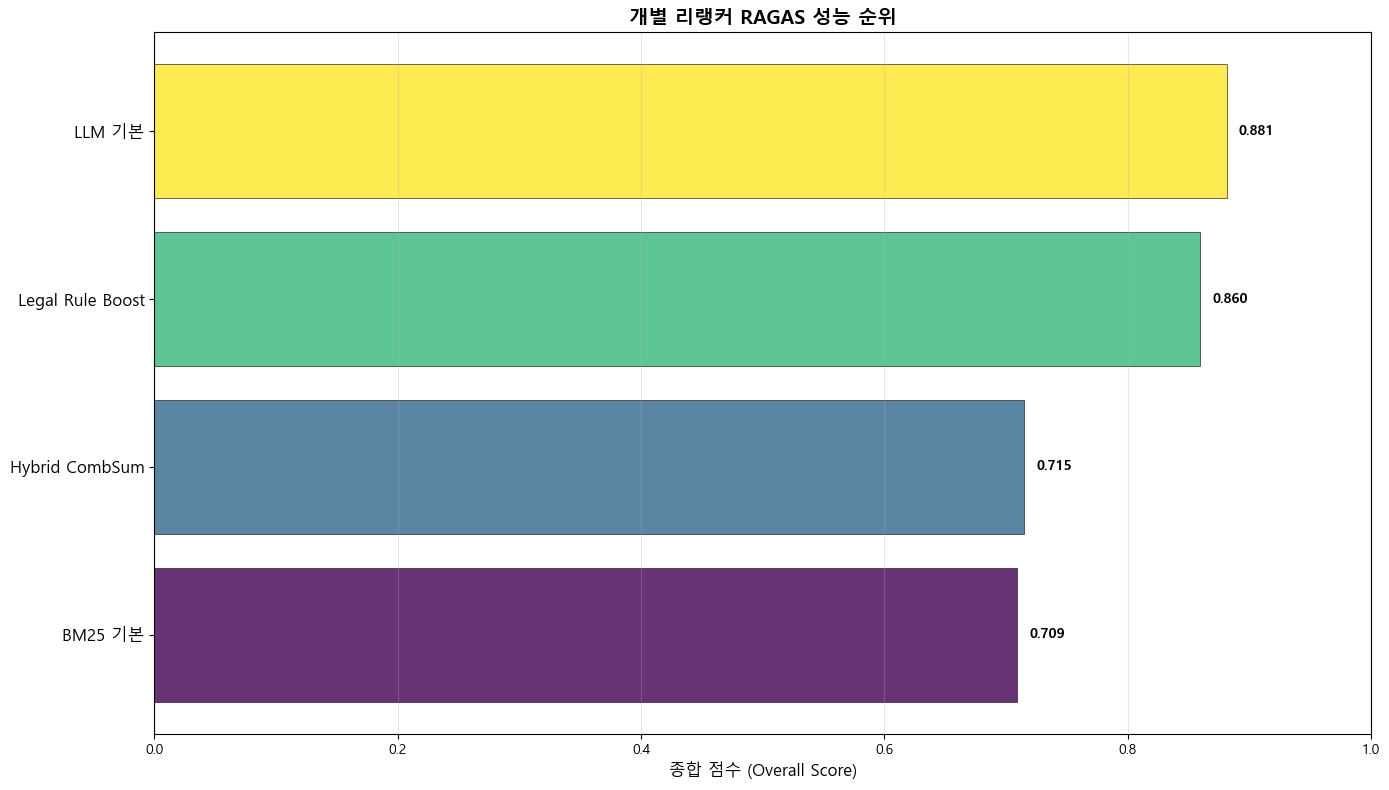

💾 시각화 저장: individual_reranker_ranking_20250915_193554.png


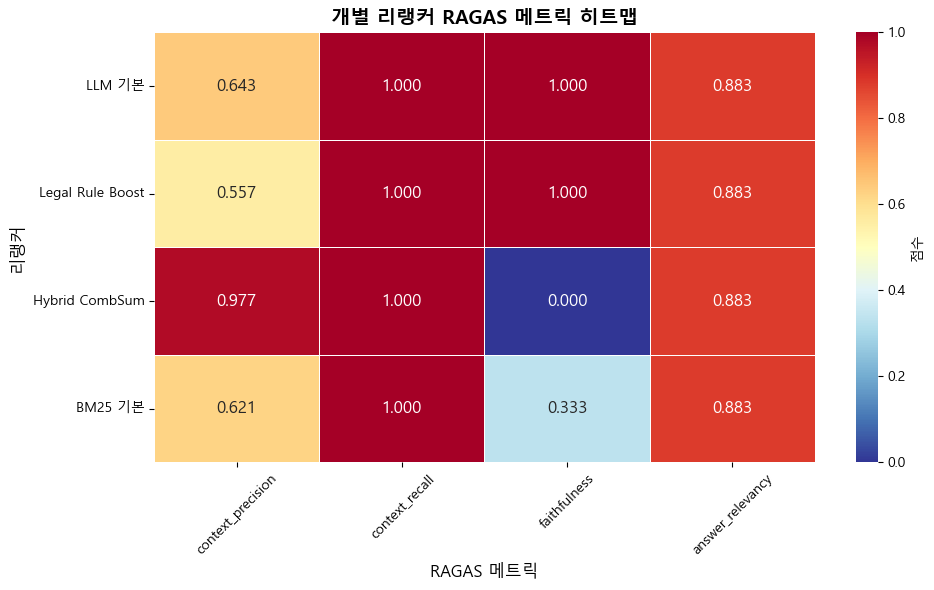

💾 히트맵 저장: individual_ragas_metrics_heatmap_20250915_193554.png

🎉 개별 평가 완료!
📁 결과 파일들:
   - individual_ragas_evaluation_results_20250915_193241.csv
   - individual_reranker_ranking_20250915_193554.png
   - individual_ragas_metrics_heatmap_20250915_193554.png


In [15]:
# 개별 평가 결과 시각화
print("📊 개별 평가 결과 시각화")
print("=" * 80)

if 'all_individual_results_df' in locals() and not all_individual_results_df.empty:
    plt.figure(figsize=(14, 8))
    
    # 종합 점수 기준 정렬
    overall_scores = all_individual_results_df['overall_score'].sort_values(ascending=True)
    
    # 막대 그래프
    colors = plt.cm.viridis(np.linspace(0, 1, len(overall_scores)))
    bars = plt.barh(range(len(overall_scores)), overall_scores.values, 
                    color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # 레이블 설정
    plt.yticks(range(len(overall_scores)), overall_scores.index, fontsize=12)
    plt.xlabel('종합 점수 (Overall Score)', fontsize=12)
    plt.title('개별 리랭커 RAGAS 성능 순위', fontsize=14, fontweight='bold')
    
    # 값 표시
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # 그리드 추가
    plt.grid(axis='x', alpha=0.3)
    plt.xlim(0, 1.0)
    
    plt.tight_layout()
    
    # 저장
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plt.savefig(f'individual_reranker_ranking_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"💾 시각화 저장: individual_reranker_ranking_{timestamp}.png")
    
    # 메트릭별 히트맵
    plt.figure(figsize=(10, 6))
    
    # 히트맵 데이터 준비
    heatmap_data = all_individual_results_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]
    
    # 히트맵 생성
    sns.heatmap(heatmap_data, 
                annot=True, 
                cmap='RdYlBu_r', 
                fmt='.3f',
                cbar_kws={'label': '점수'},
                annot_kws={'size': 12},
                linewidths=0.5)
    
    plt.title('개별 리랭커 RAGAS 메트릭 히트맵', fontsize=14, fontweight='bold')
    plt.xlabel('RAGAS 메트릭', fontsize=12)
    plt.ylabel('리랭커', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(f'individual_ragas_metrics_heatmap_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"💾 히트맵 저장: individual_ragas_metrics_heatmap_{timestamp}.png")
    
    print(f"\n🎉 개별 평가 완료!")
    print(f"📁 결과 파일들:")
    print(f"   - {individual_filename}")
    print(f"   - individual_reranker_ranking_{timestamp}.png")
    print(f"   - individual_ragas_metrics_heatmap_{timestamp}.png")
    
else:
    print("❌ 시각화할 개별 평가 결과가 없습니다.")


### 리랭커 기능 테스트

In [10]:
# 리랭킹 기능 테스트 - 실제 리랭킹 효과 확인
print("🔍 리랭킹 기능 테스트 시작...")
print("=" * 60)

def test_reranking_functionality():
    """리랭킹이 제대로 작동하는지 테스트 - 초기 검색 vs 리랭킹 결과 비교"""
    test_query = "부동산 취득세는 언제 납부해야 하나요?"
    
    print(f"📝 테스트 쿼리: {test_query}")
    print()
    
    # 각 리랭커별로 테스트
    for name, reranker in all_rerankers.items():
        print(f"🧪 {name} 테스트 중...")
        
        try:
            # 1. 초기 검색 (base retriever만 사용)
            if hasattr(reranker, 'vectorstore'):
                base_retriever = reranker.vectorstore.as_retriever(search_kwargs={"k": 20})
                initial_docs = base_retriever.invoke(test_query)
                print(f"  📊 초기 검색 결과: {len(initial_docs)}개 문서")
                
                if len(initial_docs) < 5:
                    print(f"  ⚠️  초기 검색 결과가 너무 적음 ({len(initial_docs)}개)")
                    continue
                
                # 2. 리랭킹 적용 (전체 search 메서드 사용)
                reranked_docs = reranker.search(test_query, k=10)
                print(f"  🔄 리랭킹 후 결과: {len(reranked_docs)}개 문서")
                
                # 3. 리랭킹 효과 확인 - 순서 변화 분석
                if len(initial_docs) >= 10 and len(reranked_docs) >= 5:
                    # 초기 상위 10개와 리랭킹 후 상위 5개 비교
                    initial_top10 = [doc.page_content[:100] for doc in initial_docs[:10]]
                    reranked_top5 = [doc.page_content[:100] for doc in reranked_docs[:5]]
                    
                    # 순서 변화 확인
                    order_changed = False
                    for i, reranked_content in enumerate(reranked_top5):
                        if i < len(initial_top10):
                            if reranked_content != initial_top10[i]:
                                order_changed = True
                                print(f"  ✅ 순서 변화 감지됨 (위치 {i+1})")
                                break
                    
                    if not order_changed:
                        print(f"  ⚠️  순서 변화 없음 - 리랭킹이 작동하지 않을 수 있음")
                    
                    # 4. 리랭킹 전후 상위 3개 문서 비교
                    print(f"  📋 리랭킹 전 상위 3개:")
                    for i, doc in enumerate(initial_docs[:3], 1):
                        preview = doc.page_content[:100].replace('\n', ' ')
                        print(f"    {i}. {preview}...")
                    
                    print(f"  📋 리랭킹 후 상위 3개:")
                    for i, doc in enumerate(reranked_docs[:3], 1):
                        preview = doc.page_content[:100].replace('\n', ' ')
                        print(f"    {i}. {preview}...")
                    
                    # 5. 리랭킹 효과 정량화
                    common_docs = 0
                    for reranked_doc in reranked_docs[:5]:
                        for initial_doc in initial_docs[:10]:
                            if reranked_doc.page_content[:100] == initial_doc.page_content[:100]:
                                common_docs += 1
                                break
                    
                    reranking_ratio = common_docs / len(reranked_docs[:5]) * 100
                    print(f"  📈 리랭킹 효과: {reranking_ratio:.1f}% (상위 5개 중 {common_docs}개가 초기 상위 10개에 포함)")
                    
                else:
                    print(f"  ⚠️  비교할 문서가 충분하지 않음")
            else:
                print(f"  ❌ vectorstore 속성을 찾을 수 없음")
            
            print()
            
        except Exception as e:
            print(f"  ❌ {name} 테스트 실패: {e}")
            import traceback
            print(f"    상세 오류: {traceback.format_exc()}")
            print()
    
    print("🎯 리랭킹 테스트 완료!")
    print("\n📋 테스트 결과 해석:")
    print("- ✅ 순서 변화 감지됨: 리랭킹이 정상 작동")
    print("- ⚠️  순서 변화 없음: 리랭킹이 작동하지 않을 수 있음")
    print("- 📈 리랭킹 효과: 높을수록 리랭킹이 효과적으로 작동")

# 리랭킹 테스트 실행
if all_rerankers:
    test_reranking_functionality()
else:
    print("⚠️  로드된 리랭커가 없어 테스트를 건너뜁니다.")

🔍 리랭킹 기능 테스트 시작...
📝 테스트 쿼리: 부동산 취득세는 언제 납부해야 하나요?

🧪 BM25 기본 테스트 중...
  📊 초기 검색 결과: 20개 문서
  🔄 리랭킹 후 결과: 10개 문서
  ✅ 순서 변화 감지됨 (위치 1)
  📋 리랭킹 전 상위 3개:
    1. 한 절차에 따라 그 세액이 확정된다. * 구 국세기본법시행령 (2007. 2. 28. 대통령령 제19893호로 개정되기 전의 것) 제10조의2 (납세의무의 확정) 법 제22조 제1...
    2. 여는 제1항 의 규정에 의한 세율별 과세표준에 다음 각 호의 연도별 적용비율과 제1항 의 규정에 의한 세율을 곱하여 계산한 금액을 각각 당해연도의 세액으로 한다. 1. 2006년 ...
    3. 개정되기 전의 것, 이하 같다) 제21조 는 관할세무서장의 납세의무자에 대한 종합부동산세 부과·징수를 용이하게 하기 위하여 시장·군수에게 ‘주택분 재산세의 부과자료는 7월 31일까...
  📋 리랭킹 후 상위 3개:
    1. 원칙 및 비례원칙을 위반한 것임은 물론 납세자의 재산권을 침해하는 위헌적인 것이다. 따라서 이 사건 처분 중 적법·정당하게 부과된 부분을 초과한 부분은 취소되어야 한다. 3. 관련...
    2. 산을 보유하는 데에 그 담세력을 인정하여 부과하는 조세이고, 부동산 가액을 과세표준으로 하고 있어 그 본질은 부동산의 소유 자체를 과세요건으로 하는 것이므로 그 기본적인 성격은 재...
    3. 부동산의 가격 안정이라는 구 종부세법의 입법목적 달성에 어려움이 예상되는 점 등에 비추어 볼 때, 과세표준(부동산 가액)에서 부채를 공제하지 않은 것이 자기 자본으로 부동산을 취득...
  📈 리랭킹 효과: 20.0% (상위 5개 중 1개가 초기 상위 10개에 포함)

🧪 Cohere 테스트 중...
  📊 초기 검색 결과: 20개 문서
  🔄 리랭킹 후 결과: 10개 문서
  ✅ 순서 변화 감지됨 (위치 1)
  📋 리랭킹 전 상위 3개:
    1. 한 절차에 따라 그 세액이

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('422 Client Error: unknown for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unprocessable entity: error reading multipart data: multipart: NextPart: EOF"}\n')
